# Purpose of notebook
This notebook is explore the roles classification problem. The goal of this analysis is to identify what attributes are good at predicting the role, independent of character.

Roles questions:
1. If I group the data by characters into the 4 classes (duelist, initiator, controller, sentinel) can I classify the data based on those classes (those are the labels)
    1. Ideally I would be able to see which features are driving the classification per class and in total?
2. Is it possible to cluster the data?
    1. I think features could be less important in the sense that we could observe the grouping and see what roles make sense from the data?
    2. We make this the new classes and similarly try to classify

## Additional background / hypothesis
* Commonly in gaming there is the concept of "role" similar to positions in sports
* In Valorant, characters are grouped into 4 main roles and their "kit" is designed to fill that role
    - Controller
    - Initiator
    - Duelist
    - Sentinels
* Some characters are a bit fluid (can play multiple roles) but generally the character is a good proxy for role
* However the player can ignore the kit/character and still play a different "role" even if their character isnt designed for it
* There are sub-roles
* There is a general idea that in order to have the best chance of winning, you should have a 2 sentinels, 1 initiator, 1 duelist, 1 controller

### Hypothesis/questions
* Is it possible to group players by their gameplay (how different is their gameplay)?
    * Idea: we know the different people's ids, if we cluster the data and see how many clusters it forms (DBSCAN?) will it be similar or different to the ammount of people we have?
* Is it possible to determine how well a player is playing the role assigned by the character but independent of character?
    * Idea: we gather data from the "best" professionals in each character role, and treat this as the ground truth for that role
        * then we can measure how close a player is playing that role
        * could also attempt to classify based on the ground truth
* It it possible to prove/disprove the team-comp sentiment?
    * Idea: once we have a good idea of what leads to wins/losses, we can add in different character comps and see how that influeces match outcomes? basically try and see if the ratio of characters/roles actually matters
* Is it possible to show that certain characters/roles are more important/relevant depending on the STATE of the match (what has happened??)
    * Idea: classify/catagorize matches into opening, mid, end game based on events (like chess) to determine strategy, and then see which roles are most effective at progressing the match to the next event.

Defensive:
- sentinels: support and/or in game leader
    - healing 
    - moving around the map (information)
    -Cypher; Killjoy; Chamber; and Sage
    - slowing down opponents on bomb site

- initiators: recon and crowd control
    - Sova, Skye, Fade and Gekko rely on their abilities to perform reconnaissance
    - Breach and KAY/O specialise in disrupting enemies in their path through the use of their crowd control abilities

Offensive
- controllers: secondary entry frag and lurker 
    - Ability smoke screen
    - Use abilities before spike plant
    - Astra; Brimstone; Omen; Harbor and Viper.
    - Second on the scene
    - Omen is a flank

- duelist: entry drag
    - Damage dealers
    - Jett; Phoenix; Raze; Reyna; Yoru and Neon.
    - First person on an area on a map
    - Good aim

    

https://www.pinnacle.com/en/esports-hub/betting-articles/valorant/roles-in-valorant/gx9jvkedjdeh2ygl#:~:text=the%20team%20wins.-,What%20are%20the%20different%20roles%20in%20VALORANT%3F,%2C%20Recon%2C%20and%20Crowd%20Control. 



In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import tree
import matplotlib.pyplot as plt

## Loading the data

In [3]:
import pandas as pd

# Read the CSV files into separate DataFrames
df1 = pd.read_csv('pro2_data_abilities.csv')
df2 = pd.read_csv('pro1_data_abilities.csv')
# df3 = pd.read_csv('dev_data_abilities.csv')

# Concatenate the DataFrames vertically
df = pd.concat([df1, df2], ignore_index=True)

df

,user_id,map,player,ally3_character,ally4_character,self_character,ally1_character,ally2_character,opponent5_character,opponent6_character,...,pre_spike_information_used,post_spike_information_used,pre_spike_healing_used,post_spike_healing_used,pre_spike_damage_for_team_used,post_spike_damage_for_team_used,pre_spike_crowd_control_mobility_used,post_spike_crowd_control_mobility_used,pre_spike_crowd_control_vision_used,post_spike_crowd_control_vision_used
0,3807,Pearl,2,gekko,viper,phoenix,astra,jett,harbor,killjoy,...,0,0,0,0,0,0,0,0,4,0
1,3807,Pearl,2,gekko,viper,phoenix,astra,jett,harbor,killjoy,...,0,0,0,0,0,0,0,0,2,0
2,3807,Pearl,2,gekko,viper,phoenix,astra,jett,harbor,killjoy,...,0,0,0,0,0,0,0,0,0,0
3,3807,Pearl,2,gekko,viper,phoenix,astra,jett,harbor,killjoy,...,0,0,0,0,1,0,0,0,0,2
4,3807,Pearl,2,gekko,viper,phoenix,astra,jett,harbor,killjoy,...,0,0,1,0,1,1,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20909,61,Icebox,1,viper,harbor,cypher,reyna,sage,sage,astra,...,1,1,0,0,0,0,1,0,1,1
20910,61,Icebox,1,viper,harbor,cypher,reyna,sage,sage,astra,...,2,0,0,0,0,0,1,0,2,0
20911,61,Icebox,1,viper,harbor,cypher,reyna,sage,sage,astra,...,1,1,0,0,0,0,2,0,1,1
20912,61,Icebox,1,viper,harbor,cypher,reyna,sage,sage,astra,...,2,0,0,0,0,0,1,0,2,0


In [4]:
# Find rows with NaN values
nan_rows = df[df.isnull().any(axis=1)]

# Print the rows with NaN values
nan_rows

,user_id,map,player,ally3_character,ally4_character,self_character,ally1_character,ally2_character,opponent5_character,opponent6_character,...,pre_spike_information_used,post_spike_information_used,pre_spike_healing_used,post_spike_healing_used,pre_spike_damage_for_team_used,post_spike_damage_for_team_used,pre_spike_crowd_control_mobility_used,post_spike_crowd_control_mobility_used,pre_spike_crowd_control_vision_used,post_spike_crowd_control_vision_used


In [5]:
df.columns[:100]

Index(['user_id', 'map', 'player', 'ally3_character', 'ally4_character',
       'self_character', 'ally1_character', 'ally2_character',
       'opponent5_character', 'opponent6_character', 'opponent7_character',
       'opponent8_character', 'opponent9_character', 'spike_planted',
       'spike_time', 'round_number', 'round_info_ally_side',
       'round_info_round_end', 'round_info_round_won',
       'round_info_round_start', 'ally3_pre_spike_elims',
       'ally3_post_spike_elims', 'ally3_pre_spike_deaths',
       'ally3_post_spike_deaths', 'ally3_pre_spike_assists',
       'ally3_post_spike_assists', 'ally3_pre_spike_headshots',
       'ally3_post_spike_headshots', 'ally3_pre_spike_wallbangs',
       'ally3_post_spike_wallbangs', 'ally3_pre_spike_first_bloods',
       'ally3_post_spike_first_bloods', 'ally4_pre_spike_elims',
       'ally4_post_spike_elims', 'ally4_pre_spike_deaths',
       'ally4_post_spike_deaths', 'ally4_pre_spike_assists',
       'ally4_post_spike_assists', 'ally

In [6]:
df.columns[100:200]

Index(['opponent1_pre_spike_wallbangs', 'opponent1_post_spike_wallbangs',
       'opponent1_pre_spike_first_bloods', 'opponent1_post_spike_first_bloods',
       'opponent2_pre_spike_elims', 'opponent2_post_spike_elims',
       'opponent2_pre_spike_deaths', 'opponent2_post_spike_deaths',
       'opponent2_pre_spike_assists', 'opponent2_post_spike_assists',
       'opponent2_pre_spike_headshots', 'opponent2_post_spike_headshots',
       'opponent2_pre_spike_wallbangs', 'opponent2_post_spike_wallbangs',
       'opponent2_pre_spike_first_bloods', 'opponent2_post_spike_first_bloods',
       'opponent3_pre_spike_elims', 'opponent3_post_spike_elims',
       'opponent3_pre_spike_deaths', 'opponent3_post_spike_deaths',
       'opponent3_pre_spike_assists', 'opponent3_post_spike_assists',
       'opponent3_pre_spike_headshots', 'opponent3_post_spike_headshots',
       'opponent3_pre_spike_wallbangs', 'opponent3_post_spike_wallbangs',
       'opponent3_pre_spike_first_bloods', 'opponent3_post_spi

In [7]:
df.columns[200:]

Index(['self_pre_spike_ultimate_usage', 'self_post_spike_ultimate_usage',
       'ally1_ultimate_usage', 'ally1_pre_spike_ultimate_usage',
       'ally1_post_spike_ultimate_usage', 'ally2_ultimate_usage',
       'ally2_pre_spike_ultimate_usage', 'ally2_post_spike_ultimate_usage',
       'opponent0_ultimate_usage', 'opponent0_pre_spike_ultimate_usage',
       'opponent0_post_spike_ultimate_usage', 'opponent1_ultimate_usage',
       'opponent1_pre_spike_ultimate_usage',
       'opponent1_post_spike_ultimate_usage', 'opponent2_ultimate_usage',
       'opponent2_pre_spike_ultimate_usage',
       'opponent2_post_spike_ultimate_usage', 'opponent3_ultimate_usage',
       'opponent3_pre_spike_ultimate_usage',
       'opponent3_post_spike_ultimate_usage', 'opponent4_ultimate_usage',
       'opponent4_pre_spike_ultimate_usage',
       'opponent4_post_spike_ultimate_usage', 'self_pre_spike_map_covered',
       'self_pre_spike_movement_metric', 'self_post_spike_map_covered',
       'self_post_spik

In [8]:
df.iloc[0][:50]

user_id                              3807
map                                 Pearl
player                                  2
ally3_character                     gekko
ally4_character                     viper
self_character                    phoenix
ally1_character                     astra
ally2_character                      jett
opponent5_character                harbor
opponent6_character               killjoy
opponent7_character                  jett
opponent8_character                 astra
opponent9_character                  yoru
spike_planted                       False
spike_time                              0
round_number                            0
round_info_ally_side             defender
round_info_round_end               178579
round_info_round_won                False
round_info_round_start             134795
ally3_pre_spike_elims                   0
ally3_post_spike_elims                  0
ally3_pre_spike_deaths                  1
ally3_post_spike_deaths           

In [9]:
df.iloc[0][50:]

self_pre_spike_headshots                  0
self_post_spike_headshots                 0
self_pre_spike_wallbangs                  0
self_post_spike_wallbangs                 0
self_pre_spike_first_bloods               0
                                         ..
post_spike_damage_for_team_used           0
pre_spike_crowd_control_mobility_used     0
post_spike_crowd_control_mobility_used    0
pre_spike_crowd_control_vision_used       4
post_spike_crowd_control_vision_used      0
Name: 0, Length: 222, dtype: object

## Data pre-processing
- Dropped 2 cols I don't need
- Checked to see if there are NaNs and 'unknowns'
- Because map wasn't really seeming to be a major influence on W/L ratio I am leaving the unknowns in
- However attacker vs defender could probably be an issue...


- Translated the boolean cols to 0 and 1
- One-hot encode categorical variables
- StandardScaler for numeric ...

In [10]:
df = df.drop(['player','round_number'], axis=1)

### encoding boolean features


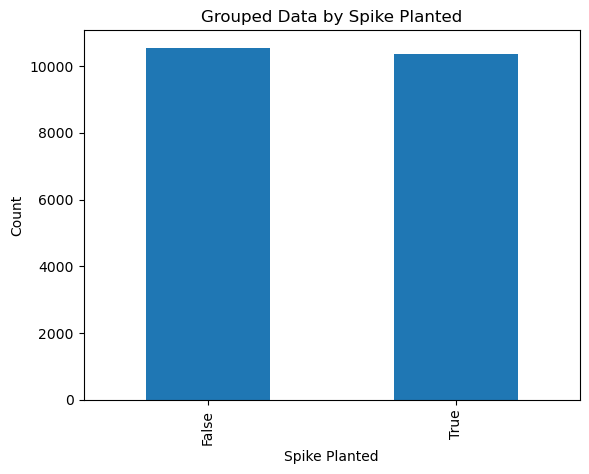

In [11]:
grouped_df = df.groupby('spike_planted').size()

grouped_df.plot(kind='bar')

plt.xlabel('Spike Planted')
plt.ylabel('Count')
plt.title('Grouped Data by Spike Planted')

plt.show()

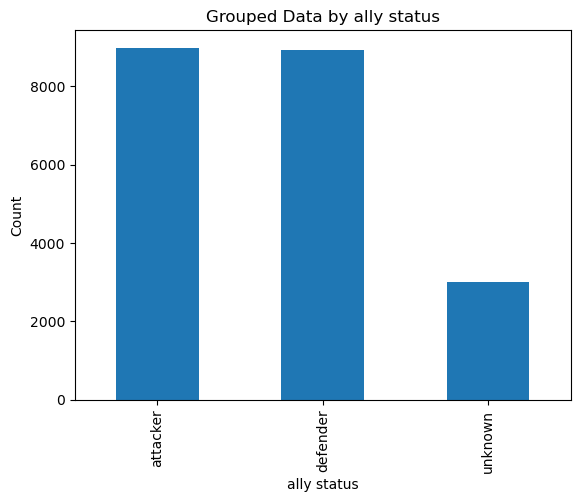

In [12]:
grouped_df = df.groupby('round_info_ally_side').size()

grouped_df.plot(kind='bar')

plt.xlabel('ally status')
plt.ylabel('Count')
plt.title('Grouped Data by ally status')

plt.show()

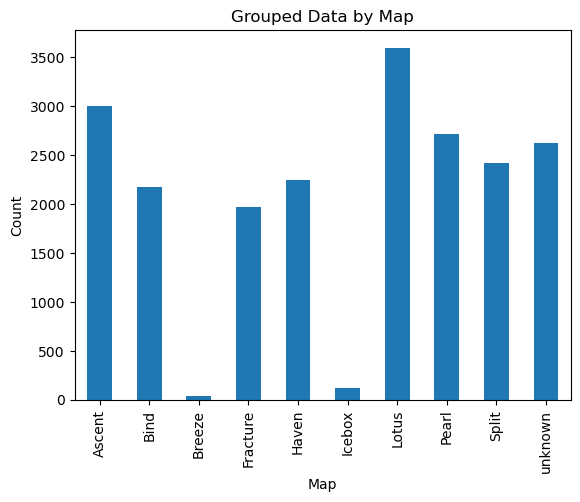

In [13]:
grouped_df = df.groupby('map').size()

grouped_df.plot(kind='bar')

plt.xlabel('Map')
plt.ylabel('Count')
plt.title('Grouped Data by Map')

plt.show()

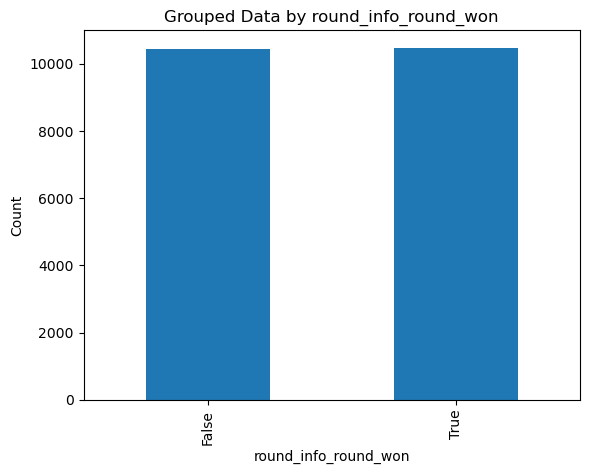

In [14]:
grouped_df = df.groupby('round_info_round_won').size()

grouped_df.plot(kind='bar')

plt.xlabel('round_info_round_won')
plt.ylabel('Count')
plt.title('Grouped Data by round_info_round_won')

plt.show()

In [15]:
mapping = {True: 1, False: 0}
df.loc[:, 'spike_planted'] = df['spike_planted'].map(mapping)
df

,user_id,map,ally3_character,ally4_character,self_character,ally1_character,ally2_character,opponent5_character,opponent6_character,opponent7_character,...,pre_spike_information_used,post_spike_information_used,pre_spike_healing_used,post_spike_healing_used,pre_spike_damage_for_team_used,post_spike_damage_for_team_used,pre_spike_crowd_control_mobility_used,post_spike_crowd_control_mobility_used,pre_spike_crowd_control_vision_used,post_spike_crowd_control_vision_used
0,3807,Pearl,gekko,viper,phoenix,astra,jett,harbor,killjoy,jett,...,0,0,0,0,0,0,0,0,4,0
1,3807,Pearl,gekko,viper,phoenix,astra,jett,harbor,killjoy,jett,...,0,0,0,0,0,0,0,0,2,0
2,3807,Pearl,gekko,viper,phoenix,astra,jett,harbor,killjoy,jett,...,0,0,0,0,0,0,0,0,0,0
3,3807,Pearl,gekko,viper,phoenix,astra,jett,harbor,killjoy,jett,...,0,0,0,0,1,0,0,0,0,2
4,3807,Pearl,gekko,viper,phoenix,astra,jett,harbor,killjoy,jett,...,0,0,1,0,1,1,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20909,61,Icebox,viper,harbor,cypher,reyna,sage,sage,astra,reyna,...,1,1,0,0,0,0,1,0,1,1
20910,61,Icebox,viper,harbor,cypher,reyna,sage,sage,astra,reyna,...,2,0,0,0,0,0,1,0,2,0
20911,61,Icebox,viper,harbor,cypher,reyna,sage,sage,astra,reyna,...,1,1,0,0,0,0,2,0,1,1
20912,61,Icebox,viper,harbor,cypher,reyna,sage,sage,astra,reyna,...,2,0,0,0,0,0,1,0,2,0


In [16]:
mapping = {True: 1, False: 0}
df.loc[:, 'round_info_round_won'] = df['round_info_round_won'].map(mapping)
df

,user_id,map,ally3_character,ally4_character,self_character,ally1_character,ally2_character,opponent5_character,opponent6_character,opponent7_character,...,pre_spike_information_used,post_spike_information_used,pre_spike_healing_used,post_spike_healing_used,pre_spike_damage_for_team_used,post_spike_damage_for_team_used,pre_spike_crowd_control_mobility_used,post_spike_crowd_control_mobility_used,pre_spike_crowd_control_vision_used,post_spike_crowd_control_vision_used
0,3807,Pearl,gekko,viper,phoenix,astra,jett,harbor,killjoy,jett,...,0,0,0,0,0,0,0,0,4,0
1,3807,Pearl,gekko,viper,phoenix,astra,jett,harbor,killjoy,jett,...,0,0,0,0,0,0,0,0,2,0
2,3807,Pearl,gekko,viper,phoenix,astra,jett,harbor,killjoy,jett,...,0,0,0,0,0,0,0,0,0,0
3,3807,Pearl,gekko,viper,phoenix,astra,jett,harbor,killjoy,jett,...,0,0,0,0,1,0,0,0,0,2
4,3807,Pearl,gekko,viper,phoenix,astra,jett,harbor,killjoy,jett,...,0,0,1,0,1,1,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20909,61,Icebox,viper,harbor,cypher,reyna,sage,sage,astra,reyna,...,1,1,0,0,0,0,1,0,1,1
20910,61,Icebox,viper,harbor,cypher,reyna,sage,sage,astra,reyna,...,2,0,0,0,0,0,1,0,2,0
20911,61,Icebox,viper,harbor,cypher,reyna,sage,sage,astra,reyna,...,1,1,0,0,0,0,2,0,1,1
20912,61,Icebox,viper,harbor,cypher,reyna,sage,sage,astra,reyna,...,2,0,0,0,0,0,1,0,2,0


In [17]:
# Find rows with NaN values
nan_rows = df[df.isnull().any(axis=1)]

# Print the rows with NaN values
nan_rows

,user_id,map,ally3_character,ally4_character,self_character,ally1_character,ally2_character,opponent5_character,opponent6_character,opponent7_character,...,pre_spike_information_used,post_spike_information_used,pre_spike_healing_used,post_spike_healing_used,pre_spike_damage_for_team_used,post_spike_damage_for_team_used,pre_spike_crowd_control_mobility_used,post_spike_crowd_control_mobility_used,pre_spike_crowd_control_vision_used,post_spike_crowd_control_vision_used


### one-hot encoding 

In [18]:
df_encoded = pd.get_dummies(df, columns=['map', 'ally4_character', 
                                        'ally1_character', 'ally2_character', 'ally3_character', 
                                        'opponent5_character', 'opponent6_character', 'opponent7_character',
                                        'opponent8_character', 'opponent9_character',
                                        'round_info_ally_side','self_longest_inv_state', 
                                        'self_longest_gun_primary','self_longest_gun_secondary',
                                         'self_post_spike_longest_inv_state','self_pre_spike_longest_inv_state',
                                         'self_post_spike_longest_gun_secondary','self_pre_spike_longest_gun_secondary'
                                        ,'self_post_spike_longest_gun_primary','self_pre_spike_longest_gun_primary'])


In [19]:
df_encoded

,user_id,self_character,spike_planted,spike_time,round_info_round_end,round_info_round_won,round_info_round_start,ally3_pre_spike_elims,ally3_post_spike_elims,ally3_pre_spike_deaths,...,self_pre_spike_longest_gun_primary_guardian,self_pre_spike_longest_gun_primary_judge,self_pre_spike_longest_gun_primary_marshal,self_pre_spike_longest_gun_primary_none,self_pre_spike_longest_gun_primary_odin,self_pre_spike_longest_gun_primary_operator,self_pre_spike_longest_gun_primary_phantom,self_pre_spike_longest_gun_primary_spectre,self_pre_spike_longest_gun_primary_stinger,self_pre_spike_longest_gun_primary_vandal
0,3807,phoenix,0,0,178579,0,134795,0,0,1,...,0,0,0,1,0,0,0,0,0,0
1,3807,phoenix,1,257180,287772,0,208579,0,0,1,...,0,0,0,1,0,0,0,0,0,0
2,3807,phoenix,0,0,377967,1,317772,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,3807,phoenix,1,471764,487358,0,407967,0,2,0,...,0,0,0,0,0,0,0,0,0,1
4,3807,phoenix,1,540359,580547,0,517358,0,0,1,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20909,61,cypher,1,1816200,1829396,1,1779806,0,1,0,...,0,0,0,1,0,0,0,0,0,0
20910,61,cypher,1,1945000,1971394,1,1859396,0,0,1,...,0,0,0,0,0,0,0,0,0,1
20911,61,cypher,1,2040200,2083414,0,2001394,1,0,1,...,0,0,0,1,0,0,0,0,0,0
20912,61,cypher,1,2148800,2178399,0,2113414,0,0,1,...,0,0,0,1,0,0,0,0,0,0


## round length

In [20]:
df_encoded['round_info_round_length'] = df_encoded['round_info_round_end'] - df_encoded['round_info_round_start']

## encode by role

In [21]:
unique_chars = df_encoded['self_character'].unique()
unique_chars

array(['phoenix', 'omen', 'killjoy', 'sova', 'viper', 'astra', 'skye',
       'cypher', 'sage', 'harbor', 'breach', 'brimstone', 'reyna',
       'chamber', 'jett', 'gekko', 'raze', 'yoru', 'neon', 'kay/o',
       'fade'], dtype=object)

In [22]:
mapping = {'killjoy':0, 'cypher':0, 'sage':0,'chamber':0, 
           'brimstone':1, 'omen':1,'viper':1,'astra':1,'harbor':1,
          'jett':2, 'phoenix':2,'raze':2, 'reyna':2,'neon':2, 'yoru':2,
           'gekko':3, 'breach':3, 'fade':3, 'kay/o':3, 'skye':3,'sova':3}
df_encoded.loc[:, 'self_character'] = df_encoded['self_character'].map(mapping)
df_encoded

,user_id,self_character,spike_planted,spike_time,round_info_round_end,round_info_round_won,round_info_round_start,ally3_pre_spike_elims,ally3_post_spike_elims,ally3_pre_spike_deaths,...,self_pre_spike_longest_gun_primary_judge,self_pre_spike_longest_gun_primary_marshal,self_pre_spike_longest_gun_primary_none,self_pre_spike_longest_gun_primary_odin,self_pre_spike_longest_gun_primary_operator,self_pre_spike_longest_gun_primary_phantom,self_pre_spike_longest_gun_primary_spectre,self_pre_spike_longest_gun_primary_stinger,self_pre_spike_longest_gun_primary_vandal,round_info_round_length
0,3807,2,0,0,178579,0,134795,0,0,1,...,0,0,1,0,0,0,0,0,0,43784
1,3807,2,1,257180,287772,0,208579,0,0,1,...,0,0,1,0,0,0,0,0,0,79193
2,3807,2,0,0,377967,1,317772,0,0,0,...,0,0,0,0,0,0,0,0,1,60195
3,3807,2,1,471764,487358,0,407967,0,2,0,...,0,0,0,0,0,0,0,0,1,79391
4,3807,2,1,540359,580547,0,517358,0,0,1,...,0,0,1,0,0,0,0,0,0,63189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20909,61,0,1,1816200,1829396,1,1779806,0,1,0,...,0,0,1,0,0,0,0,0,0,49590
20910,61,0,1,1945000,1971394,1,1859396,0,0,1,...,0,0,0,0,0,0,0,0,1,111998
20911,61,0,1,2040200,2083414,0,2001394,1,0,1,...,0,0,1,0,0,0,0,0,0,82020
20912,61,0,1,2148800,2178399,0,2113414,0,0,1,...,0,0,1,0,0,0,0,0,0,64985


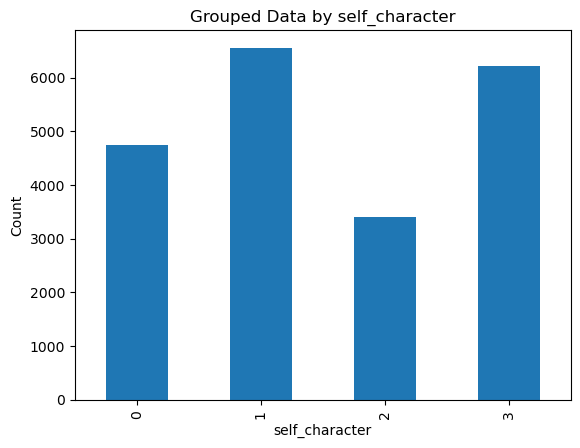

In [23]:
grouped_df = df_encoded.groupby('self_character').size()

grouped_df.plot(kind='bar')

plt.xlabel('self_character')
plt.ylabel('Count')
plt.title('Grouped Data by self_character')

plt.show()

In [24]:
# Find rows with NaN values
nan_rows = df_encoded[df_encoded.isnull().any(axis=1)]

# Print the rows with NaN values
nan_rows

,user_id,self_character,spike_planted,spike_time,round_info_round_end,round_info_round_won,round_info_round_start,ally3_pre_spike_elims,ally3_post_spike_elims,ally3_pre_spike_deaths,...,self_pre_spike_longest_gun_primary_judge,self_pre_spike_longest_gun_primary_marshal,self_pre_spike_longest_gun_primary_none,self_pre_spike_longest_gun_primary_odin,self_pre_spike_longest_gun_primary_operator,self_pre_spike_longest_gun_primary_phantom,self_pre_spike_longest_gun_primary_spectre,self_pre_spike_longest_gun_primary_stinger,self_pre_spike_longest_gun_primary_vandal,round_info_round_length


### Downsampling
-

## Decision Tree Classifier

### All data

In [25]:
df_dtree = df_encoded.copy()
df_dtree

,user_id,self_character,spike_planted,spike_time,round_info_round_end,round_info_round_won,round_info_round_start,ally3_pre_spike_elims,ally3_post_spike_elims,ally3_pre_spike_deaths,...,self_pre_spike_longest_gun_primary_judge,self_pre_spike_longest_gun_primary_marshal,self_pre_spike_longest_gun_primary_none,self_pre_spike_longest_gun_primary_odin,self_pre_spike_longest_gun_primary_operator,self_pre_spike_longest_gun_primary_phantom,self_pre_spike_longest_gun_primary_spectre,self_pre_spike_longest_gun_primary_stinger,self_pre_spike_longest_gun_primary_vandal,round_info_round_length
0,3807,2,0,0,178579,0,134795,0,0,1,...,0,0,1,0,0,0,0,0,0,43784
1,3807,2,1,257180,287772,0,208579,0,0,1,...,0,0,1,0,0,0,0,0,0,79193
2,3807,2,0,0,377967,1,317772,0,0,0,...,0,0,0,0,0,0,0,0,1,60195
3,3807,2,1,471764,487358,0,407967,0,2,0,...,0,0,0,0,0,0,0,0,1,79391
4,3807,2,1,540359,580547,0,517358,0,0,1,...,0,0,1,0,0,0,0,0,0,63189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20909,61,0,1,1816200,1829396,1,1779806,0,1,0,...,0,0,1,0,0,0,0,0,0,49590
20910,61,0,1,1945000,1971394,1,1859396,0,0,1,...,0,0,0,0,0,0,0,0,1,111998
20911,61,0,1,2040200,2083414,0,2001394,1,0,1,...,0,0,1,0,0,0,0,0,0,82020
20912,61,0,1,2148800,2178399,0,2113414,0,0,1,...,0,0,1,0,0,0,0,0,0,64985


In [26]:
# train test split
X = df_dtree.drop('self_character', axis=1)
y = df_dtree['self_character']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# # Scale the data
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

In [27]:
def d_tree(X_train,y_train,X_test,y_test):
    dtc = DecisionTreeClassifier(random_state=1)
    dtc.fit(X_train, y_train)
    y_pred = dtc.predict(X_test)
    y_pred_train = dtc.predict(X_train)
    print("Train Accuracy:", accuracy_score(y_train, y_pred_train))
    print(confusion_matrix(y_train, y_pred_train))
    print(classification_report(y_test, y_pred))

    print("Test Accuracy:", accuracy_score(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    
    return dtc

In [28]:
def f_importance(dtc):
    feature_importances = pd.DataFrame(dtc.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
    return feature_importances
    

In [29]:
dtc = d_tree(X_train,y_train,X_test,y_test)

Train Accuracy: 1.0
[[3765    0    0    0]
 [   0 5238    0    0]
 [   0    0 2757    0]
 [   0    0    0 4971]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       979
           1       0.99      0.99      0.99      1317
           2       0.98      0.98      0.98       650
           3       0.99      0.99      0.99      1237

    accuracy                           0.99      4183
   macro avg       0.99      0.99      0.99      4183
weighted avg       0.99      0.99      0.99      4183

Test Accuracy: 0.9897202964379632
[[ 971    5    2    1]
 [   2 1304    4    7]
 [   3    5  639    3]
 [   0    6    5 1226]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       979
           1       0.99      0.99      0.99      1317
           2       0.98      0.98      0.98       650
           3       0.99      0.99      0.99      1237

    accuracy                           0.99      4183

In [30]:
feature_importances = f_importance(dtc)

In [31]:
feature_importances[:50]

,importance
user_id,0.182609
opponent6_character_killjoy,0.037126
ally1_character_omen,0.033342
self_pre_spike_total_ability_usage_3,0.028865
self_pre_spike_map_covered,0.028855
pre_spike_damage_for_self_used,0.027720
pre_spike_crowd_control_vision_used,0.026670
ally3_character_skye,0.025809
opponent8_character_raze,0.024406
pre_spike_information_used,0.024381


## trying again w no user id

In [32]:
df_no_userid = df_encoded.copy()
df_no_userid = df_no_userid.drop('user_id', axis=1)
df_no_userid

,self_character,spike_planted,spike_time,round_info_round_end,round_info_round_won,round_info_round_start,ally3_pre_spike_elims,ally3_post_spike_elims,ally3_pre_spike_deaths,ally3_post_spike_deaths,...,self_pre_spike_longest_gun_primary_judge,self_pre_spike_longest_gun_primary_marshal,self_pre_spike_longest_gun_primary_none,self_pre_spike_longest_gun_primary_odin,self_pre_spike_longest_gun_primary_operator,self_pre_spike_longest_gun_primary_phantom,self_pre_spike_longest_gun_primary_spectre,self_pre_spike_longest_gun_primary_stinger,self_pre_spike_longest_gun_primary_vandal,round_info_round_length
0,2,0,0,178579,0,134795,0,0,1,0,...,0,0,1,0,0,0,0,0,0,43784
1,2,1,257180,287772,0,208579,0,0,1,0,...,0,0,1,0,0,0,0,0,0,79193
2,2,0,0,377967,1,317772,0,0,0,0,...,0,0,0,0,0,0,0,0,1,60195
3,2,1,471764,487358,0,407967,0,2,0,1,...,0,0,0,0,0,0,0,0,1,79391
4,2,1,540359,580547,0,517358,0,0,1,0,...,0,0,1,0,0,0,0,0,0,63189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20909,0,1,1816200,1829396,1,1779806,0,1,0,0,...,0,0,1,0,0,0,0,0,0,49590
20910,0,1,1945000,1971394,1,1859396,0,0,1,0,...,0,0,0,0,0,0,0,0,1,111998
20911,0,1,2040200,2083414,0,2001394,1,0,1,0,...,0,0,1,0,0,0,0,0,0,82020
20912,0,1,2148800,2178399,0,2113414,0,0,1,0,...,0,0,1,0,0,0,0,0,0,64985


In [33]:
# train test split
X_nouser = df_no_userid.drop('self_character', axis=1)
y_nouser = df_no_userid['self_character']

X_train, X_test, y_train, y_test = train_test_split(X_nouser, y_nouser, test_size=0.2, random_state=1)

In [34]:
dtc_nouser = d_tree(X_train,y_train,X_test,y_test)

Train Accuracy: 1.0
[[3765    0    0    0]
 [   0 5238    0    0]
 [   0    0 2757    0]
 [   0    0    0 4971]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       979
           1       0.99      0.98      0.99      1317
           2       0.96      0.96      0.96       650
           3       0.99      0.99      0.99      1237

    accuracy                           0.98      4183
   macro avg       0.98      0.98      0.98      4183
weighted avg       0.98      0.98      0.98      4183

Test Accuracy: 0.9835046617260339
[[ 973    2    4    0]
 [   2 1294   15    6]
 [   6   13  622    9]
 [   2    1    9 1225]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       979
           1       0.99      0.98      0.99      1317
           2       0.96      0.96      0.96       650
           3       0.99      0.99      0.99      1237

    accuracy                           0.98      4183

In [35]:
feature_importances = f_importance(dtc_nouser)
feature_importances[:50]

,importance
self_pre_spike_total_ability_usage_3,0.057596
pre_spike_damage_for_self_used,0.044649
ally3_character_jett,0.037379
pre_spike_information_used,0.035966
opponent9_character_raze,0.032855
ally3_character_skye,0.026137
ally3_character_phoenix,0.022688
pre_spike_shield_used,0.022034
ally1_character_omen,0.021596
map_Pearl,0.021010


## trying again w no user id, team characters 

In [36]:
df_no_chars = df_no_userid.copy()
columns_to_drop = [col for col in df_no_chars.columns if col.startswith('ally3_character')]
df_no_chars.drop(columns_to_drop, axis=1, inplace=True)

columns_to_drop = [col for col in df_no_chars.columns if col.startswith('ally1_character')]
df_no_chars.drop(columns_to_drop, axis=1, inplace=True)

columns_to_drop = [col for col in df_no_chars.columns if col.startswith('ally2_character')]
df_no_chars.drop(columns_to_drop, axis=1, inplace=True)

columns_to_drop = [col for col in df_no_chars.columns if col.startswith('ally4_character')]
df_no_chars.drop(columns_to_drop, axis=1, inplace=True)

columns_to_drop = [col for col in df_no_chars.columns if col.startswith('opponent7_character')]
df_no_chars.drop(columns_to_drop, axis=1, inplace=True)

columns_to_drop = [col for col in df_no_chars.columns if col.startswith('opponent6_character')]
df_no_chars.drop(columns_to_drop, axis=1, inplace=True)

columns_to_drop = [col for col in df_no_chars.columns if col.startswith('opponent5_character')]
df_no_chars.drop(columns_to_drop, axis=1, inplace=True)

columns_to_drop = [col for col in df_no_chars.columns if col.startswith('opponent8_character')]
df_no_chars.drop(columns_to_drop, axis=1, inplace=True)

columns_to_drop = [col for col in df_no_chars.columns if col.startswith('opponent9_character')]
df_no_chars.drop(columns_to_drop, axis=1, inplace=True)

In [37]:
df_no_chars

,self_character,spike_planted,spike_time,round_info_round_end,round_info_round_won,round_info_round_start,ally3_pre_spike_elims,ally3_post_spike_elims,ally3_pre_spike_deaths,ally3_post_spike_deaths,...,self_pre_spike_longest_gun_primary_judge,self_pre_spike_longest_gun_primary_marshal,self_pre_spike_longest_gun_primary_none,self_pre_spike_longest_gun_primary_odin,self_pre_spike_longest_gun_primary_operator,self_pre_spike_longest_gun_primary_phantom,self_pre_spike_longest_gun_primary_spectre,self_pre_spike_longest_gun_primary_stinger,self_pre_spike_longest_gun_primary_vandal,round_info_round_length
0,2,0,0,178579,0,134795,0,0,1,0,...,0,0,1,0,0,0,0,0,0,43784
1,2,1,257180,287772,0,208579,0,0,1,0,...,0,0,1,0,0,0,0,0,0,79193
2,2,0,0,377967,1,317772,0,0,0,0,...,0,0,0,0,0,0,0,0,1,60195
3,2,1,471764,487358,0,407967,0,2,0,1,...,0,0,0,0,0,0,0,0,1,79391
4,2,1,540359,580547,0,517358,0,0,1,0,...,0,0,1,0,0,0,0,0,0,63189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20909,0,1,1816200,1829396,1,1779806,0,1,0,0,...,0,0,1,0,0,0,0,0,0,49590
20910,0,1,1945000,1971394,1,1859396,0,0,1,0,...,0,0,0,0,0,0,0,0,1,111998
20911,0,1,2040200,2083414,0,2001394,1,0,1,0,...,0,0,1,0,0,0,0,0,0,82020
20912,0,1,2148800,2178399,0,2113414,0,0,1,0,...,0,0,1,0,0,0,0,0,0,64985


In [38]:
# train test split
X_nocharnouser = df_no_chars.drop('self_character', axis=1)
y_nocharnouser= df_no_chars['self_character']

X_train, X_test, y_train, y_test = train_test_split(X_nocharnouser, y_nocharnouser, test_size=0.2, random_state=1)

In [39]:
dtc_nousernochar = d_tree(X_train,y_train,X_test,y_test)

Train Accuracy: 1.0
[[3765    0    0    0]
 [   0 5238    0    0]
 [   0    0 2757    0]
 [   0    0    0 4971]]
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       979
           1       0.91      0.91      0.91      1317
           2       0.81      0.81      0.81       650
           3       0.91      0.90      0.90      1237

    accuracy                           0.89      4183
   macro avg       0.88      0.88      0.88      4183
weighted avg       0.89      0.89      0.89      4183

Test Accuracy: 0.8893138895529524
[[ 870   30   41   38]
 [  29 1205   42   41]
 [  49   37  528   36]
 [  32   47   41 1117]]
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       979
           1       0.91      0.91      0.91      1317
           2       0.81      0.81      0.81       650
           3       0.91      0.90      0.90      1237

    accuracy                           0.89      4183

In [40]:
feature_importances = f_importance(dtc_nousernochar)
feature_importances[:50]

,importance
self_pre_spike_total_ability_usage_3,0.080148
pre_spike_crowd_control_vision_used,0.066644
pre_spike_information_used,0.053838
pre_spike_damage_for_self_used,0.048201
pre_spike_shield_used,0.043998
pre_spike_damage_for_team_used,0.037375
self_pre_spike_total_ability_usage_1,0.029679
self_pre_spike_total_ability_usage_2,0.027432
ally1_pre_spike_total_health_loss,0.027051
ally4_pre_spike_avg_health,0.026105


## trying again w no map

In [41]:
df_no_map = df_no_chars.copy()
columns_to_drop = [col for col in df_no_chars.columns if col.startswith('map_')]
df_no_map.drop(columns_to_drop, axis=1, inplace=True)
df_no_map

,self_character,spike_planted,spike_time,round_info_round_end,round_info_round_won,round_info_round_start,ally3_pre_spike_elims,ally3_post_spike_elims,ally3_pre_spike_deaths,ally3_post_spike_deaths,...,self_pre_spike_longest_gun_primary_judge,self_pre_spike_longest_gun_primary_marshal,self_pre_spike_longest_gun_primary_none,self_pre_spike_longest_gun_primary_odin,self_pre_spike_longest_gun_primary_operator,self_pre_spike_longest_gun_primary_phantom,self_pre_spike_longest_gun_primary_spectre,self_pre_spike_longest_gun_primary_stinger,self_pre_spike_longest_gun_primary_vandal,round_info_round_length
0,2,0,0,178579,0,134795,0,0,1,0,...,0,0,1,0,0,0,0,0,0,43784
1,2,1,257180,287772,0,208579,0,0,1,0,...,0,0,1,0,0,0,0,0,0,79193
2,2,0,0,377967,1,317772,0,0,0,0,...,0,0,0,0,0,0,0,0,1,60195
3,2,1,471764,487358,0,407967,0,2,0,1,...,0,0,0,0,0,0,0,0,1,79391
4,2,1,540359,580547,0,517358,0,0,1,0,...,0,0,1,0,0,0,0,0,0,63189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20909,0,1,1816200,1829396,1,1779806,0,1,0,0,...,0,0,1,0,0,0,0,0,0,49590
20910,0,1,1945000,1971394,1,1859396,0,0,1,0,...,0,0,0,0,0,0,0,0,1,111998
20911,0,1,2040200,2083414,0,2001394,1,0,1,0,...,0,0,1,0,0,0,0,0,0,82020
20912,0,1,2148800,2178399,0,2113414,0,0,1,0,...,0,0,1,0,0,0,0,0,0,64985


In [42]:
# train test split
X_nocharnousernomap = df_no_map.drop('self_character', axis=1)
y_nocharnousernomap = df_no_map['self_character']

X_train, X_test, y_train, y_test = train_test_split(X_nocharnousernomap, y_nocharnousernomap, test_size=0.2, random_state=1)

In [43]:
dtc_nousernocharnomap = d_tree(X_train,y_train,X_test,y_test)

Train Accuracy: 1.0
[[3765    0    0    0]
 [   0 5238    0    0]
 [   0    0 2757    0]
 [   0    0    0 4971]]
              precision    recall  f1-score   support

           0       0.90      0.88      0.89       979
           1       0.91      0.91      0.91      1317
           2       0.80      0.82      0.81       650
           3       0.90      0.91      0.91      1237

    accuracy                           0.89      4183
   macro avg       0.88      0.88      0.88      4183
weighted avg       0.89      0.89      0.89      4183

Test Accuracy: 0.8890748266794167
[[ 864   39   49   27]
 [  20 1201   46   50]
 [  33   45  530   42]
 [  38   38   37 1124]]
              precision    recall  f1-score   support

           0       0.90      0.88      0.89       979
           1       0.91      0.91      0.91      1317
           2       0.80      0.82      0.81       650
           3       0.90      0.91      0.91      1237

    accuracy                           0.89      4183

In [44]:
feature_importances = f_importance(dtc_nousernocharnomap)
feature_importances[:50]

,importance
self_pre_spike_total_ability_usage_3,0.079759
pre_spike_crowd_control_vision_used,0.070513
pre_spike_information_used,0.058247
pre_spike_damage_for_self_used,0.048201
pre_spike_shield_used,0.043743
pre_spike_damage_for_team_used,0.038735
ally1_pre_spike_total_health_loss,0.033267
self_pre_spike_map_covered,0.030967
ally4_pre_spike_avg_health,0.028187
ally1_pre_spike_avg_health,0.027902


In [45]:
# train test split
X_nocharnousernomap = df_no_map.drop('self_character', axis=1)
y_nocharnousernomap = df_no_map['self_character']

X_train, X_test, y_train, y_test = train_test_split(X_nocharnousernomap, y_nocharnousernomap, test_size=0.2, random_state=1)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [51]:
feature_importances = dtc_nousernocharnomap.feature_importances_
feature_importances_df = pd.DataFrame({'Feature': X_nocharnousernomap.columns, 'Importance': feature_importances})
top_k = 50
selected_features = feature_importances_df.head(top_k)['Feature'].values
filtered_df = df_no_map[selected_features]
filtered_df

,spike_planted,spike_time,round_info_round_end,round_info_round_won,round_info_round_start,ally3_pre_spike_elims,ally3_post_spike_elims,ally3_pre_spike_deaths,ally3_post_spike_deaths,ally3_pre_spike_assists,...,self_post_spike_first_bloods,ally1_pre_spike_elims,ally1_post_spike_elims,ally1_pre_spike_deaths,ally1_post_spike_deaths,ally1_pre_spike_assists,ally1_post_spike_assists,ally1_pre_spike_headshots,ally1_post_spike_headshots,ally1_pre_spike_wallbangs
0,0,0,178579,0,134795,0,0,1,0,0,...,0,0,0,1,0,1,0,0,0,0
1,1,257180,287772,0,208579,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,377967,1,317772,0,0,0,0,0,...,0,2,0,0,0,0,0,1,0,0
3,1,471764,487358,0,407967,0,2,0,1,0,...,0,0,0,1,0,0,0,0,0,0
4,1,540359,580547,0,517358,0,0,1,0,0,...,0,0,1,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20909,1,1816200,1829396,1,1779806,0,1,0,0,0,...,0,2,1,0,0,0,0,0,1,0
20910,1,1945000,1971394,1,1859396,0,0,1,0,2,...,0,1,0,2,0,0,0,1,0,0
20911,1,2040200,2083414,0,2001394,1,0,1,0,0,...,0,1,0,1,0,0,0,0,0,0
20912,1,2148800,2178399,0,2113414,0,0,1,0,0,...,0,1,0,1,0,0,0,1,0,0


In [52]:
specific_feature_column = df_encoded['self_character']
new_df = pd.concat([filtered_df, specific_feature_column], axis=1)
new_df

,spike_planted,spike_time,round_info_round_end,round_info_round_won,round_info_round_start,ally3_pre_spike_elims,ally3_post_spike_elims,ally3_pre_spike_deaths,ally3_post_spike_deaths,ally3_pre_spike_assists,...,ally1_pre_spike_elims,ally1_post_spike_elims,ally1_pre_spike_deaths,ally1_post_spike_deaths,ally1_pre_spike_assists,ally1_post_spike_assists,ally1_pre_spike_headshots,ally1_post_spike_headshots,ally1_pre_spike_wallbangs,self_character
0,0,0,178579,0,134795,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,2
1,1,257180,287772,0,208579,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,2
2,0,0,377967,1,317772,0,0,0,0,0,...,2,0,0,0,0,0,1,0,0,2
3,1,471764,487358,0,407967,0,2,0,1,0,...,0,0,1,0,0,0,0,0,0,2
4,1,540359,580547,0,517358,0,0,1,0,0,...,0,1,0,1,0,0,0,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20909,1,1816200,1829396,1,1779806,0,1,0,0,0,...,2,1,0,0,0,0,0,1,0,0
20910,1,1945000,1971394,1,1859396,0,0,1,0,2,...,1,0,2,0,0,0,1,0,0,0
20911,1,2040200,2083414,0,2001394,1,0,1,0,0,...,1,0,1,0,0,0,0,0,0,0
20912,1,2148800,2178399,0,2113414,0,0,1,0,0,...,1,0,1,0,0,0,1,0,0,0


In [53]:
# train test split
X_f = new_df.drop('self_character', axis=1)
y_f = new_df['self_character']

X_train, X_test, y_train, y_test = train_test_split(X_f, y_f, test_size=0.2, random_state=1)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [54]:
dtc = d_tree(X_train,y_train,X_test,y_test)

Train Accuracy: 1.0
[[3765    0    0    0]
 [   0 5238    0    0]
 [   0    0 2757    0]
 [   0    0    0 4971]]
              precision    recall  f1-score   support

           0       0.76      0.75      0.76       979
           1       0.79      0.82      0.81      1317
           2       0.52      0.47      0.50       650
           3       0.81      0.83      0.82      1237

    accuracy                           0.75      4183
   macro avg       0.72      0.72      0.72      4183
weighted avg       0.75      0.75      0.75      4183

Test Accuracy: 0.7528089887640449
[[ 733   82  100   64]
 [  71 1082  104   60]
 [  97  127  308  118]
 [  59   76   76 1026]]
              precision    recall  f1-score   support

           0       0.76      0.75      0.76       979
           1       0.79      0.82      0.81      1317
           2       0.52      0.47      0.50       650
           3       0.81      0.83      0.82      1237

    accuracy                           0.75      4183

/Users/sophiacofone/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/sophiacofone/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


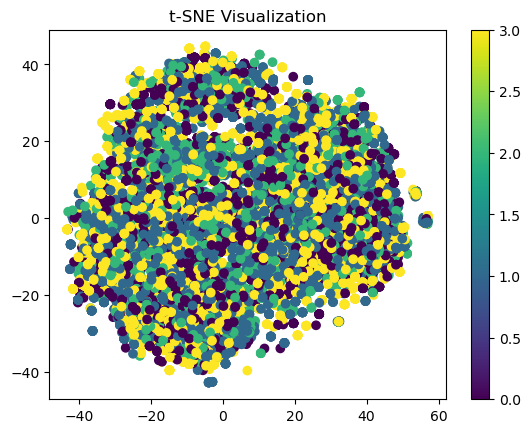

In [57]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2,perplexity=500, init='pca').fit_transform(X_train_scaled)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y_train)
plt.colorbar()
plt.title('t-SNE Visualization')
plt.show()